In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
import os
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import random
import numpy as np

In [ ]:
!pip install torchinfo

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features=768, out_features=60).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 203MB/s]


In [ ]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size = (32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
VisionTransformer                             [32, 3, 224, 224]         [32, 60]                  768                       Partial
├─Conv2d: 1-1                                 [32, 3, 224, 224]         [32, 768, 14, 14]         (590,592)                 False
├─Encoder: 1-2                                [32, 197, 768]            [32, 197, 768]            151,296                   False
│    └─Dropout: 2-1                           [32, 197, 768]            [32, 197, 768]            --                        --
│    └─Sequential: 2-2                        [32, 197, 768]            [32, 197, 768]            --                        False
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]            [32, 197, 768]            (7,087,872)               False
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]            [32, 197, 768] 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Train_dataset_path = '/content/drive/MyDrive/Reverse/Train'
Validation_dataset_path = '/content/drive/MyDrive/Reverse/Validation'
Test_dataset_path = '/content/drive/MyDrive/Reverse/Test'

models_path='/content/drive/My Drive/ViT_Models/ViT_Initial.pth'

In [ ]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    val_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS
):
    # Create datasets for each directory
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_dataloader, val_dataloader, test_dataloader

In [ ]:
train_dataloader_pretrained, val_dataloader_pretrained, test_dataloader_pretrained = create_dataloaders(
    train_dir=Train_dataset_path,
    val_dir=Validation_dataset_path,
    test_dir=Test_dataset_path,
    transform=pretrained_vit_transforms,
    batch_size=32
)

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy).

    """

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy).

    """
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():

        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
                              train_dataloader: torch.utils.data.DataLoader,
                              test_dataloader: torch.utils.data.DataLoader,
                              optimizer: torch.optim.Optimizer,
                              loss_fn: torch.nn.Module,
                              epochs: int,
                              device: torch.device,
                              patience: int) -> Dict[str, List]:
    """
    Trains and tests a PyTorch model with early stopping.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    patience: An integer indicating how many epochs to wait for improvement
              in validation loss before stopping early.

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics.
    """

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    model.to(device)

    # Early stopping variables
    best_loss = float('inf')
    patience_counter = 0

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)


        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        if test_loss < best_loss:
            best_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1

        # Stop training if patience is exceeded
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break

    return results

In [ ]:
#Loss function
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
# Create optimizer and loss function
optimizer = torch.optim.AdamW(params=pretrained_vit.parameters(),
                             lr=1e-3)

# Train the classifier head of the pretrained ViT feature extractor model
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=val_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=100,
                                      device=device,
                                      patience=3)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3740 | train_acc: 0.5687 | test_loss: 1.3444 | test_acc: 0.7947
Epoch: 2 | train_loss: 0.8879 | train_acc: 0.8854 | test_loss: 0.7583 | test_acc: 0.8917
Epoch: 3 | train_loss: 0.5150 | train_acc: 0.9379 | test_loss: 0.5575 | test_acc: 0.9163
Epoch: 4 | train_loss: 0.3631 | train_acc: 0.9569 | test_loss: 0.4592 | test_acc: 0.9245
Epoch: 5 | train_loss: 0.2731 | train_acc: 0.9692 | test_loss: 0.3881 | test_acc: 0.9360
Epoch: 6 | train_loss: 0.2148 | train_acc: 0.9796 | test_loss: 0.3379 | test_acc: 0.9451
Epoch: 7 | train_loss: 0.1747 | train_acc: 0.9823 | test_loss: 0.3138 | test_acc: 0.9385
Epoch: 8 | train_loss: 0.1456 | train_acc: 0.9877 | test_loss: 0.2924 | test_acc: 0.9459
Epoch: 9 | train_loss: 0.1229 | train_acc: 0.9888 | test_loss: 0.2714 | test_acc: 0.9500
Epoch: 10 | train_loss: 0.1069 | train_acc: 0.9908 | test_loss: 0.2591 | test_acc: 0.9476
Epoch: 11 | train_loss: 0.0907 | train_acc: 0.9935 | test_loss: 0.2519 | test_acc: 0.9443
Epoch: 12 | train_l

In [ ]:
#Save the model
torch.save(obj=pretrained_vit.state_dict(), f=models_path)

In [ ]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

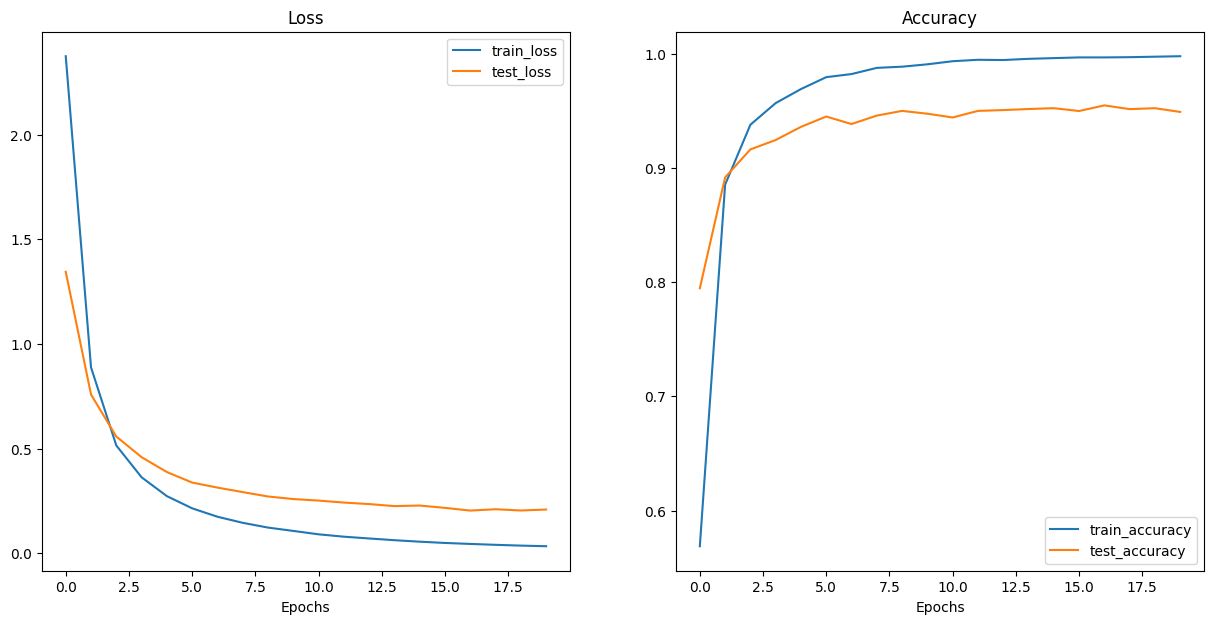

In [ ]:
plot_loss_curves(pretrained_vit_results)

In [ ]:
# Load the model
pretrained_vit.load_state_dict(torch.load(models_path))

# Perform evaluation on the test set
final_test_loss, final_test_acc = test_step(
    model=pretrained_vit,
    dataloader=test_dataloader_pretrained,
    loss_fn=loss_fn,
    device=device
)

print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_acc:.4f}")